In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [15]:
# Read the data from the CSV file
df = pd.read_csv('fraud_oracle.csv')

day_mapping = {
    'Monday': 'Mon',
    'Tuesday': 'Tue',
    'Wednesday': 'Wed',
    'Thursday': 'Thu',
    'Friday': 'Fri',
    'Saturday': 'Sat',
    'Sunday': 'Sun'
}

# Combine the columns into a new 'DATE' column with a custom format
date_strings = df['Year'].astype(str) + '-' + df['Month'] + '-' + df['WeekOfMonth'].astype(str) + '-' + df['DayOfWeek'].map(day_mapping)
df['DATE'] = pd.to_datetime(date_strings, format='%Y-%b-%d-%a')

# Drop the original columns
df.drop(['Month', 'WeekOfMonth', 'DayOfWeek', 'Year'], axis=1, inplace=True)

print(df.DATE)

0       1994-12-05
1       1994-01-03
2       1994-10-05
3       1994-06-02
4       1994-01-05
           ...    
15415   1996-11-04
15416   1996-11-05
15417   1996-11-05
15418   1996-12-01
15419   1996-12-02
Name: DATE, Length: 15420, dtype: datetime64[ns]


In [9]:
columns_to_remove = ['Fault', 'VehicleCategory', 'PolicyNumber', 'RepNumber',"MonthClaimed", "DayOfWeekClaimed", "DriverRating", "Days_Policy_Accident", "DATE", "WeekOfMonthClaimed"]
final = df.drop(columns=columns_to_remove)

print(final.head())

     Make AccidentArea     Sex MaritalStatus  Age         PolicyType  \
0   Honda        Urban  Female        Single   21  Sport - Liability   
1   Honda        Urban    Male        Single   34  Sport - Collision   
2   Honda        Urban    Male       Married   47  Sport - Collision   
3  Toyota        Rural    Male       Married   65  Sedan - Liability   
4   Honda        Urban  Female        Single   27  Sport - Collision   

      VehiclePrice  FraudFound_P  Deductible Days_Policy_Claim  \
0  more than 69000             0         300      more than 30   
1  more than 69000             0         400      more than 30   
2  more than 69000             0         400      more than 30   
3   20000 to 29000             0         400      more than 30   
4  more than 69000             0         400      more than 30   

  PastNumberOfClaims AgeOfVehicle AgeOfPolicyHolder PoliceReportFiled  \
0               none      3 years          26 to 30                No   
1               none    

In [10]:
# Separate features and target variable
X = final.drop(columns=['FraudFound_P'])
y = final['FraudFound_P']

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Identify numerical columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Initialize LabelEncoder for categorical columns
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns
X_encoded = X.copy()
X_encoded[categorical_columns] = X[categorical_columns].apply(label_encoder.fit_transform)

# Apply feature scaling to numerical columns
scaler = StandardScaler()
X_encoded[numerical_columns] = scaler.fit_transform(X_encoded[numerical_columns])

In [11]:
print(X_encoded.columns)
print(X_encoded)

Index(['Make', 'AccidentArea', 'Sex', 'MaritalStatus', 'Age', 'PolicyType',
       'VehiclePrice', 'Deductible', 'Days_Policy_Claim', 'PastNumberOfClaims',
       'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled',
       'WitnessPresent', 'AgentType', 'NumberOfSuppliments',
       'AddressChange_Claim', 'NumberOfCars', 'BasePolicy'],
      dtype='object')
       Make  AccidentArea  Sex  MaritalStatus       Age  PolicyType  \
0         6             1    0              2 -1.397554           5   
1         6             1    1              2 -0.434015           4   
2         6             1    1              1  0.529523           4   
3        17             0    1              1  1.863653           2   
4         6             1    0              2 -0.952844           4   
...     ...           ...  ...            ...       ...         ...   
15415    17             1    1              1 -0.359897           1   
15416    13             1    1              1 -0.730489           2

In [12]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [13]:
# Initialize the Random Forest classifier
random_forest_model = RandomForestClassifier()

# Fit the model to the training data
random_forest_model.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = random_forest_model.score(X_test, y_test)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.9328793774319066


In [14]:
# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Get the top 10 important features
top_10_features = feature_importance_df.head(10)

print(top_10_features)

                Feature  Importance
4                   Age    0.264965
0                  Make    0.140662
15  NumberOfSuppliments    0.090355
10         AgeOfVehicle    0.087912
9    PastNumberOfClaims    0.085015
6          VehiclePrice    0.062444
11    AgeOfPolicyHolder    0.056610
3         MaritalStatus    0.040227
5            PolicyType    0.028091
1          AccidentArea    0.025856


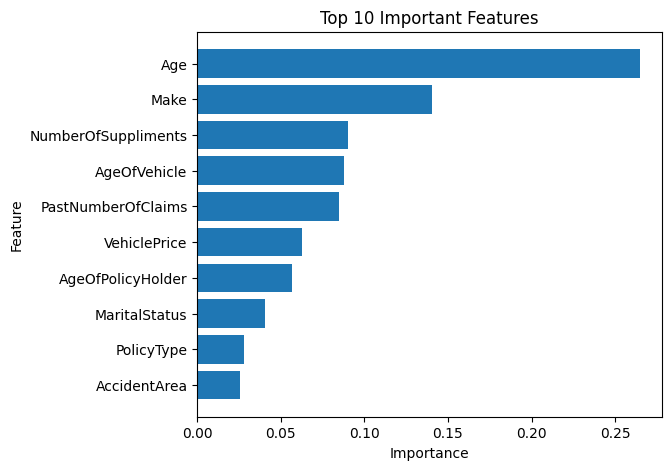

In [18]:
import matplotlib.pyplot as plt

# Assuming you have the top_10_features DataFrame

# Plot the barh plot
plt.figure(figsize=(6, 5))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


In [19]:
Data_top_10 = X_encoded[top_10_features['Feature']]
Data_top_10.set_index(y, inplace=True)

print(Data_top_10.head())

Data_top_10.to_csv('improvement_top_10_features.csv')

                   Age  Make  NumberOfSuppliments  AgeOfVehicle  \
FraudFound_P                                                      
0            -1.397554     6                    3             1   
0            -0.434015     6                    3             4   
0             0.529523     6                    3             5   
0             1.863653    17                    2             6   
0            -0.952844     6                    3             3   

              PastNumberOfClaims  VehiclePrice  AgeOfPolicyHolder  \
FraudFound_P                                                        
0                              3             5                  3   
0                              3             5                  4   
0                              0             5                  6   
0                              0             0                  7   
0                              3             5                  4   

              MaritalStatus  PolicyType  Accid